# Feature Engineering

In [1]:
%load_ext IPython.extensions.autoreload
%autoreload 2

!pip install seaborn

In [2]:
import sys,os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import numpy as np
from src.data_reader import DataSource, read_vertices_VTK, num_vertices_VTK
from src.descriptors.dscs_driver import compute_descriptors

from src.utils import get_free_id, write_jsonl, clear_jsonl
from src.descriptors.spherical_sectors import spherical_block_permutations

!pip install numpy==1.23.0

In [4]:
from gudhi import RipsComplex, AlphaComplex, plot_persistence_diagram
from gudhi.representations import ProminentPoints
from gudhi.representations import PersistenceImage

In [5]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

import joblib

In [6]:
import csv

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary as torch_summary

from IPython.display import display, clear_output

from src.learning.nn import SimpleNN, train, predict

### Load Data

In [483]:
Model = 'Combined'

data_base = './data/data/'

save_descs_path = os.path.join(data_base,'saved_descriptors/train_set/')

data = np.load(os.path.join(save_descs_path,Model+'Data.npy'))
labels = np.load(os.path.join(save_descs_path,Model+'Labels.npy'))

print(data.shape, labels.shape)

(9244, 17) (9244,)


In [491]:
data = np.delete(data, 12, axis=1)
data.shape

(9244, 16)

In [521]:
Model = 'AlphaProminent'

data_base = './data/data/'

save_descs_path = os.path.join(data_base,'saved_descriptors/train_set/')

data2 = np.load(os.path.join(save_descs_path,Model+'Data.npy'))
#data2 = np.load(os.path.join(save_descs_path,'EncodedAlphaProminent.npy'))
labels2 = np.load(os.path.join(save_descs_path,Model+'Labels.npy'))

print(data2.shape, labels2.shape)

(9244, 75) (9244,)


In [709]:
dataS = np.load('./data/sectors/saved_descriptors/train_set/sector_sublevel.npy')
dataS.shape

(9244, 104)

In [23]:
dataS = np.load('./data/sectors/saved_descriptors/test_set/sector_sublevel.npy')
dataS.shape

(2321, 104)

In [710]:
labelsS = np.load('./data/data/saved_descriptors/train_set/AlphaProminentLabels.npy')
labelsS.shape

(9244,)

### Train Data

In [8]:
dataAlpha_aug = np.load('./data/data/saved_descriptors/train_set/AlphaProminent_aug.npy')
dataS_aug = np.load('./data/sectors/saved_descriptors/train_set/AugmentedData.npy')
labels = np.load('./data/sectors/saved_descriptors/train_set/AugmentedLabels.npy')

In [9]:
data = np.concatenate( [dataS_aug , dataAlpha_aug] , axis = 1 )
#data = np.concatenate( [ dataAlpha_aug] , axis = 1 )

### Test Data

In [12]:
TestDataAlpha_aug = np.load('./data/data/saved_descriptors/test_set/AlphaProminent_aug.npy')
TestDataS_aug = np.load('./data/sectors/saved_descriptors/test_set/TestAugmentedData.npy')

In [13]:
TestData = np.concatenate( [TestDataS_aug , TestDataAlpha_aug] , axis = 1 )
#TestData = np.concatenate( [ TestDataEncAlpha_aug] , axis = 1 )

### Check data distributions

In [14]:
data.shape

(73952, 171)

In [15]:
TestData.shape

(18568, 171)

In [16]:
plt.plot(data2[:,5],'.')

NameError: name 'data2' is not defined

In [421]:
means[25:50]

array([1.76934497e+01, 3.60303015e-01, 1.59971513e-01, 6.92511987e-02,
       1.31992064e-01, 4.51104434e+00, 1.99264002e-01, 7.94191003e-02,
       3.84670654e-02, 7.19899765e-02, 1.60228478e+00, 8.97209651e-02,
       3.33485276e-02, 1.57676032e-02, 2.99942031e-02, 7.24317167e-01,
       5.25469911e-02, 2.07076927e-02, 8.57686581e-03, 1.68881605e-02,
       3.76017596e-01, 4.64445209e-02, 1.77817983e-02, 5.92794743e-03,
       1.29447926e-02])

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
SSc = StandardScaler()

In [19]:
#dataS = SSc.fit_transform(dataS, labels)
dataS = SSc.fit_transform(dataS)

NameError: name 'dataS' is not defined

In [23]:
means = np.mean(dataAlpha_aug, axis = 0)
stds = np.std(dataAlpha_aug, axis = 0)

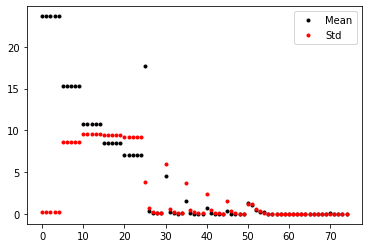

In [24]:
plt.plot(means,'.k', label='Mean')
plt.plot(stds,'.r', label='Std')
plt.legend()

In [26]:
TestMeans = np.mean(TestDataAlpha_aug, axis = 0)
TestStds = np.std(TestDataAlpha_aug, axis = 0)

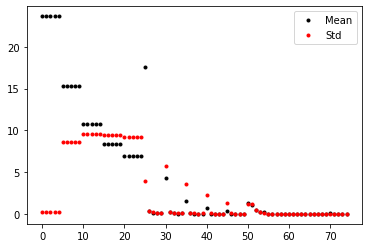

In [27]:
plt.plot(TestMeans,'.k', label='Mean')
plt.plot(TestStds,'.r', label='Std')
plt.legend()

In [38]:
np.argwhere(TestStds < .01)

array([[59],
       [60],
       [61],
       [62],
       [63],
       [64],
       [65],
       [66],
       [67],
       [68],
       [69],
       [70],
       [71],
       [72],
       [73],
       [74]])

### Visualize correlations

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


n, p = data.shape[0], data.shape[1]


# Initialize R^2 matrix
R2_matrix = np.zeros((p, p))

# Compute R^2 for each pair of features
for i in range(p):
    for j in range(p):
        if i == j:
            R2_matrix[i, j] = 1.0  # R^2 of a feature with itself is 1

        if j < i:
            R2_matrix[i, j] = R2_matrix[j, i]
        else:
            model = LinearRegression().fit(data[:, i].reshape(-1, 1), data[:, j])
            R2_matrix[i, j] = model.score(data[:, i].reshape(-1, 1), data[:, j])

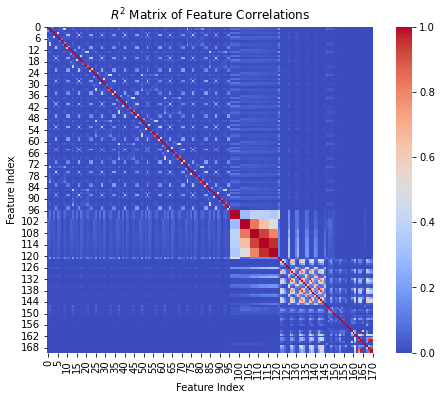

In [19]:
# Plot the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(R2_matrix, annot=False, cmap="coolwarm", fmt=".2f", square=True)
plt.title("$R^2$ Matrix of Feature Correlations")
plt.xlabel("Feature Index")
plt.ylabel("Feature Index")
plt.show()

12.0

In [31]:
exclude = [ 8 + 13*k for k in range(8) ]
list(sorted(exclude))

dataS = np.delete(dataS, exclude, axis = 1)

In [37]:
# decorrelate sectors
for k in range(8):
    q1 = 3 + 12*k
    q2 = 4 + 12*k
    q3 = 5 + 12*k

    reg1 = LinearRegression().fit(dataS[:, [q2]], dataS[:, q1])
    reg3 = LinearRegression().fit(dataS[:, [q2]], dataS[:, q3])

    # Compute residuals
    res1 = dataS[:, q1] - reg1.predict(dataS[:, [q2]])
    res3 = dataS[:, q3] - reg3.predict(dataS[:, [q2]])

    # substitute
    dataS[:,q1] = res1
    dataS[:,q3] = res3
    

In [524]:
n, p = data.shape[0], data.shape[1]


# Initialize R^2 matrix
R2_matrix = np.zeros((p, p))

# Compute R^2 for each pair of features
for i in range(p):
    for j in range(p):
        if i == j:
            R2_matrix[i, j] = 1.0  # R^2 of a feature with itself is 1
        if j < i:
            R2_matrix[i, j] = R2_matrix[j, i]
        else:
            model = LinearRegression().fit(data[:, i].reshape(-1, 1), data[:, j])
            R2_matrix[i, j] = model.score(data[:, i].reshape(-1, 1), data[:, j])

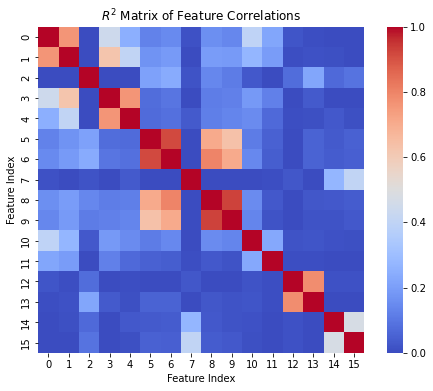

In [525]:
# Plot the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(R2_matrix, annot=False, cmap="coolwarm", fmt=".2f", square=True)
plt.title("$R^2$ Matrix of Feature Correlations")
plt.xlabel("Feature Index")
plt.ylabel("Feature Index")
plt.show()

### Try to decorrelate quantiles

In [316]:
for i in [4,3,2,1]:
    data[:,i] -= data[:,i-1]

In [317]:
for i in [9,8,7,6]:
    data[:,i] -= data[:,i-1]

### Try with linear regression

In [494]:
for i in [0,1,3,4]:
    reg = LinearRegression().fit(data[:, [2]], data[:, i])

    # Compute residuals
    res = data[:, i] - reg.predict(data[:, [2]])

    # substitute
    data[:,i] = res


In [495]:
for i in [5,6,8,9]:
    reg = LinearRegression().fit(data[:, [7]], data[:, i])

    # Compute residuals
    res = data[:, i] - reg.predict(data[:, [7]])

    # substitute
    data[:,i] = res

In [246]:
class_mask = np.where(labels==80)[0]

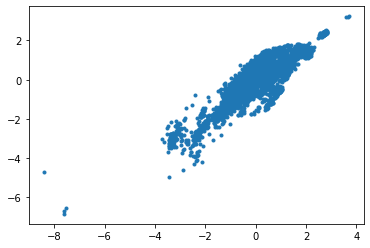

In [462]:
plt.plot(data[:,0], data[:,1], '.')

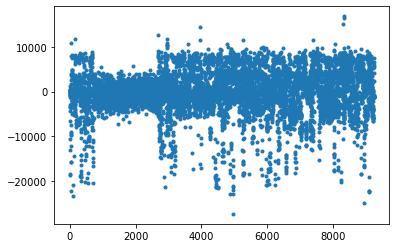

In [339]:
plt.plot( data[:,7], '.')

### Combine

In [531]:
all_data = np.concatenate([data, data2], axis=1)
#all_data = data

all_data.shape

(9244, 91)

### Cross-validation

In [729]:
StrShSp = StratifiedShuffleSplit(n_splits=15, train_size=0.8, random_state=None)

# get indices of split
train_idx, val_idx = next(StrShSp.split(dataS, labelsS))

train_data = dataS[train_idx,:]
train_labels = labelsS[train_idx]

val_data = dataS[val_idx]
val_labels = labelsS[val_idx]

In [730]:
N_Estimators = 150
criterion = 'entropy'


forest = RandomForestClassifier(n_estimators=N_Estimators, criterion=criterion)
forest.fit(train_data, train_labels)

RandomForestClassifier(criterion='entropy', n_estimators=150)

In [731]:
pred_labels = forest.predict(val_data)

In [732]:
acc = accuracy_score(val_labels, pred_labels)

print(acc)

0.8193618171984857


In [733]:
print(classification_report(val_labels, pred_labels, zero_division=0.0))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.00      0.00      0.00         1
           2       1.00      0.33      0.50         3
           3       0.67      0.50      0.57         4
           4       1.00      0.33      0.50         3
           5       0.92      0.96      0.94        25
           6       1.00      0.20      0.33         5
           7       1.00      0.80      0.89        15
           8       0.82      1.00      0.90       411
           9       0.92      0.85      0.88        13
          10       1.00      1.00      1.00         3
          11       1.00      0.78      0.88         9
          12       1.00      0.50      0.67         2
          13       1.00      0.25      0.40         4
          14       0.62      0.93      0.75        98
          15       0.95      1.00      0.97        18
          16       0.82      1.00      0.90        31
          17       0.92    

In [734]:
np.unique(pred_labels).shape

(71,)

In [736]:
np.save('ThisData.npy',dataS)

In [20]:
dataS = np.load('ThisData.npy')

In [21]:
dataS.shape

(9244, 96)

## Notes
For the **sublevel set filtration**
- In sublevelset **there is no H_2**
- Using only `quantiles[0]` and `charge[0]` yelds 68%, but using all quantiles and all charges yields 84.5%.
So maybe use more steps! A finer subdivision of the steps.
- It also seems that the more important parts of the quantile function are those close to the **extremes**
- Also, maybe move to the residuals wrt a linear regression

For the **Alpha filtration**
- With 5x5 persistent images, using all 75 columns yields 63%, using only every fifth column yields 60%

In [566]:

res[1][4]

array([], shape=(0, 2), dtype=float64)

In [572]:
source = DataSource( './data/small_sectors/sublevelset_filtrations/train_set/', base_path='./data/small_sectors/sublevelset_filtrations/train_set/')
shapes = []

for j,s in enumerate(source):
    res = np.load( s, allow_pickle=True )

    for x in range(8):
        shapes.append(res[x+1][4].shape[0])



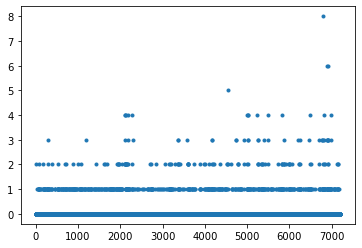

In [573]:
plt.plot(shapes, '.')

In [71]:
dataS = np.load('./data/sectors/saved_descriptors/train_set/AugmentedData.npy')
dataS.shape

(73952, 96)

In [75]:
dataSNotAug = dataS[ ::8 , :]

In [80]:
np.save( './data/sectors/saved_descriptors/train_set/TrainData.npy' , dataSNotAug )

# Data Augmentation

In [48]:
dataS_aug = np.zeros( ( dataS.shape[0] * 8 , dataS.shape[1] ) )

In [49]:
for r in range(dataS.shape[0]):
    vec = dataS[r,:].reshape(-1)


    aug_vec = np.array( spherical_block_permutations(vec, int(dataS.shape[1]/8) ) )
    dataS_aug[ 8*r : 8*r + 8 , : ] = aug_vec

    

In [50]:
vec = dataS[r,:].reshape(-1)
vec_aug = spherical_block_permutations(vec , 12)

In [51]:
np.save('TestAugmentedData.npy', dataS_aug)

## the labels too

In [795]:
labels_aug = np.column_stack( [labels]*8 )

In [797]:
labels_aug = labels_aug.reshape(-1)

In [800]:
np.save('AugmentedLabels.npy', labels_aug)

In [789]:
vec = np.array([1,2,3])

In [791]:
v = np.column_stack( [ vec ]*8 )

In [794]:
v.reshape(-1)

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3])

### The encoded data

In [63]:
dataAlpha = np.load( './data/data/saved_descriptors/test_set/AlphaProminentData.npy')

In [64]:
means = np.mean(dataAlpha, axis=0)
stds = np.std(dataAlpha, axis=0)

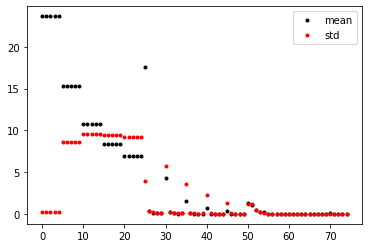

In [65]:
plt.plot(means, '.k', label='mean')
plt.plot(stds, '.r',label='std')
plt.legend()

### Augment: just copy 8 times

In [66]:
dataAlpha_aug = np.repeat(dataAlpha, repeats=8, axis=0)

In [67]:
np.save( './data/data/saved_descriptors/test_set/AlphaProminent_aug.npy', dataAlpha_aug)

### Save test sector data, normalized, not augmented

In [47]:
np.save('TestSectorData.npy', dataS)

## AlphaProminent data cleaning
Instead of using the NN encoder

In [39]:
dataAlpha_aug = np.load('./data/data/saved_descriptors/train_set/AlphaProminent_aug.npy')
TestDataAlpha_aug = np.load('./data/data/saved_descriptors/test_set/AlphaProminent_aug.npy')

labels = np.load('./data/sectors/saved_descriptors/train_set/AugmentedLabels.npy')

- The variance is too small in the last features (concerning $H_2$ of the alpha filtration). **REMOVE** features with stardard deviation less than .01, which happen to be the last 16 entries
- There is significant correlation between the $H_0$ features (the first 25). In particular, these are 5x5 set of blocks on the persistence diagram, and within each row (or column?) there is basically no variance. So for the first 25 features, only keep one every 5. And then, decorrelate them

In [23]:
means = np.mean(dataAlpha_aug, axis = 0)
stds = np.std(dataAlpha_aug, axis = 0)

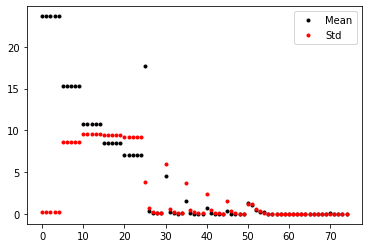

In [24]:
plt.plot(means,'.k', label='Mean')
plt.plot(stds,'.r', label='Std')
plt.legend()

In [26]:
TestMeans = np.mean(TestDataAlpha_aug, axis = 0)
TestStds = np.std(TestDataAlpha_aug, axis = 0)

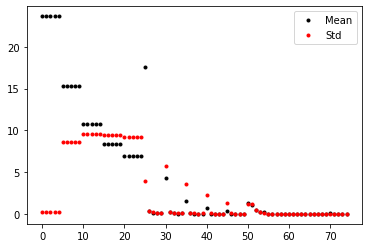

In [27]:
plt.plot(TestMeans,'.k', label='Mean')
plt.plot(TestStds,'.r', label='Std')
plt.legend()

In [41]:
np.argwhere(TestStds < .01)

array([[59],
       [60],
       [61],
       [62],
       [63],
       [64],
       [65],
       [66],
       [67],
       [68],
       [69],
       [70],
       [71],
       [72],
       [73],
       [74]])

### Visualize correlations

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


n, p = CleandataAlpha_aug.shape[0], CleandataAlpha_aug.shape[1]


# Initialize R^2 matrix
R2_matrix = np.zeros((p, p))

# Compute R^2 for each pair of features
for i in range(p):
    for j in range(p):
        if i == j:
            R2_matrix[i, j] = 1.0  # R^2 of a feature with itself is 1

        if j < i:
            R2_matrix[i, j] = R2_matrix[j, i]
        else:
            model = LinearRegression().fit(CleandataAlpha_aug[:, i].reshape(-1, 1), CleandataAlpha_aug[:, j])
            R2_matrix[i, j] = model.score(CleandataAlpha_aug[:, i].reshape(-1, 1), CleandataAlpha_aug[:, j])

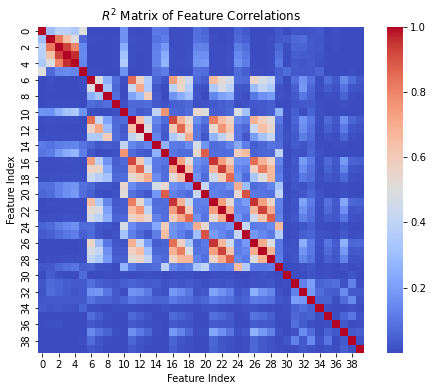

In [69]:
# Plot the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(R2_matrix, annot=False, cmap="coolwarm", fmt=".2f", square=True)
plt.title("$R^2$ Matrix of Feature Correlations")
plt.xlabel("Feature Index")
plt.ylabel("Feature Index")
plt.show()

### Cleaned Data

In [70]:
CleandataAlpha_aug = np.concatenate( [ dataAlpha_aug[:, 0:25:5] , dataAlpha_aug[:, 25:-16] ] , axis=1)

In [76]:
CleanTestDataAlpha_aug = np.concatenate( [ TestDataAlpha_aug[:, 0:25:5] , TestDataAlpha_aug[:, 25:-16] ] , axis=1)

In [80]:
CleandataAlpha_aug.shape[0]/8

9244.0

In [79]:
CleanTestDataAlpha_aug

2321.0

In [47]:
CleandataAlpha_aug[0,:]

array([2.37102801e+01, 1.49555627e+01, 3.67534080e+00, 4.44275249e-01,
       1.71794231e-01, 1.76362711e+01, 2.29212661e-01, 2.74466531e-01,
       1.14852061e-11, 1.64770287e-01, 8.08282491e-01, 2.03689693e-01,
       1.80888582e-02, 4.49692317e-12, 9.97177316e-03, 1.94813563e-04,
       1.18207830e-01, 9.35316504e-06, 2.70354960e-15, 1.99411101e-06,
       3.05971096e-04, 4.34009110e-02, 7.39627049e-09, 2.49398869e-21,
       1.38981476e-12, 3.98574255e-05, 4.31774593e-05, 1.67610532e-14,
       3.52936551e-30, 1.88931637e-21, 1.19600606e+00, 7.89140397e-01,
       3.78969109e-01, 9.85365873e-02, 2.22069687e-01, 1.06092717e-18,
       2.40776654e-04, 3.99682382e-22, 1.00926543e-21])

In [72]:
means = np.mean(CleandataAlpha_aug, axis = 0)
stds = np.std(CleandataAlpha_aug, axis = 0)

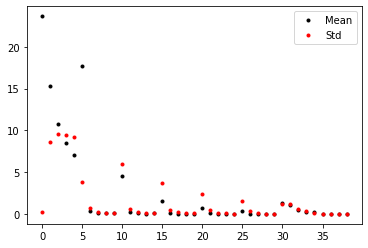

In [73]:
plt.plot(means,'.k', label='Mean')
plt.plot(stds,'.r', label='Std')
plt.legend()

In [60]:
dataAlpha_aug[0,:]

array([2.37102801e+001, 2.37102801e+001, 2.37102801e+001, 2.37102801e+001,
       2.37102801e+001, 1.49555627e+001, 1.49555627e+001, 1.49555627e+001,
       1.49555627e+001, 1.49555627e+001, 3.67534080e+000, 3.67534080e+000,
       3.67534080e+000, 3.67534080e+000, 3.67534080e+000, 4.44275249e-001,
       4.44275249e-001, 4.44275249e-001, 4.44275249e-001, 4.44275249e-001,
       1.71794231e-001, 1.71794231e-001, 1.71794231e-001, 1.71794231e-001,
       1.71794231e-001, 1.76362711e+001, 2.29212661e-001, 2.74466531e-001,
       1.14852061e-011, 1.64770287e-001, 8.08282491e-001, 2.03689693e-001,
       1.80888582e-002, 4.49692317e-012, 9.97177316e-003, 1.94813563e-004,
       1.18207830e-001, 9.35316504e-006, 2.70354960e-015, 1.99411101e-006,
       3.05971096e-004, 4.34009110e-002, 7.39627049e-009, 2.49398869e-021,
       1.38981476e-012, 3.98574255e-005, 4.31774593e-005, 1.67610532e-014,
       3.52936551e-030, 1.88931637e-021, 1.19600606e+000, 7.89140397e-001,
       3.78969109e-001, 9

In [81]:
means = np.mean(CleanTestDataAlpha_aug, axis = 0)
stds = np.std(CleanTestDataAlpha_aug, axis = 0)

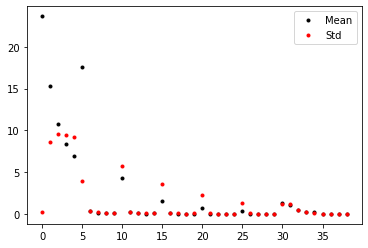

In [82]:
plt.plot(means,'.k', label='Mean')
plt.plot(stds,'.r', label='Std')
plt.legend()

In [63]:
CleandataAlpha_aug[0,:].shape

(39,)

In [62]:
dataAlpha_aug[0, 0:25:5]

array([23.71028008, 14.95556266,  3.6753408 ,  0.44427525,  0.17179423])

In [83]:
np.save('./data/data/saved_descriptors/train_set/CleanAlphaProminent_aug.npy', CleandataAlpha_aug)

In [84]:
np.save('./data/data/saved_descriptors/test_set/CleanAlphaProminent_aug.npy', CleanTestDataAlpha_aug)